<a id='TOC'/>

### TOC (table of content)
1. [Loading packages](#loading_packages)
2. [Loading data](#loading_data)
3. [Vectorizer](#vectorizer)
4. [Model](#model)
5. [Improvements](#improvements)

<a id='loading_packages'/>

### Loading packages
[Back to TOC](#TOC)

In [49]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import xgboost as xgb


import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /home/karol/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/karol/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

<a id='loading_data'/>

### Loading data
[Back to TOC](#TOC)

In [2]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df=df_train.copy()
print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB


Let's have a look at the train and test dataset.

They contain:
- id
- keyword: A keyword from that tweet (although this may be blank!)
- location: The location the tweet was sent from (may also be blank)
- text: The text of a tweet
- target: 1 if the tweet is a real disaster or 0 if not

In [3]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
print(
    "The data contains {} actual disasters ({:.2%} of all data).".format(
        df[df.target == 1].shape[0],
        df[df.target == 1].shape[0] / df.shape[0],
    )
)

The data contains 3271 actual disasters (42.97% of all data).


In [5]:
print(
    "Examples of actual disaster tweet: \n    {}\n    {}".format(
        df[df.target == 1].sample(1).text.iloc[0],
        df[df.target == 1].sample(1).text.iloc[0],
    )
)
print(
    "\nExamples of a tweet with no disaster behind it: \n    {}\n    {}".format(
        df[df.target == 0].sample(1).text.iloc[0],
        df[df.target == 0].sample(1).text.iloc[0],
    )
)

Examples of actual disaster tweet: 
    @nycdivorcelaw TRUMP IS A CLIMATE DENIER- algae bloom in the pacific from calif to alska- seeweed in caribean forest fires- SNOWBALL INHOFE
    Strikers in Phalaborwa striking over the CHINESE taking their jobs. Strikers burning buildings attacking cars 2... http://t.co/08LnGClZsj

Examples of a tweet with no disaster behind it: 
    The Body Bags has a show on 08/07/2015 at 07:30 PM @ Tremont Music Hall in Charlotte NC http://t.co/FpKiqbus9r #concert
    #AyekoRadio play Brasswork Agency - Crushed and Shaken http://t.co/Qh5axvhWH5 #Radio #NetLabel #ElectronicMusic #listen #CCMusic


<a id='vectorizer'/>

### Vectorizer
[Back to TOC](#TOC)

In [6]:
X_train, X_val, y_train, y_val = train_test_split(df_train["text"], df_train["target"], random_state=777,test_size=0.2)
X_test = df_test["text"]

Transform the text so that each word is a separate feature and count how many times that word occurs. (Save as a sparse matrix.)

In [7]:
# Fit the CountVectorizer to the training data
vect = CountVectorizer().fit(X_train)

# transform the text in the training data to a text-term matrix
X_train_vectorized = vect.transform(X_train)

vect

CountVectorizer()

Vocabulary sample:

In [8]:
sorted(vect.vocabulary_.items())[4000:4010]

[('concert', 4000),
 ('concluded', 4001),
 ('concludes', 4002),
 ('conclusions', 4003),
 ('conclusively', 4004),
 ('concrete', 4005),
 ('concur', 4006),
 ('concussion', 4007),
 ('condemn', 4008),
 ('condemnation', 4009)]

In [9]:
print(
    "The training data contains {} different words (columns) across {} messages (rows).".format( 
                                                            len(vect.vocabulary_.items()),
                                                            X_train.shape[0]
                                                           )
     )

The training data contains 18519 different words (columns) across 6090 messages (rows).


Show the (sparse) feature matrix:

In [10]:
X_train_vectorized.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

<a id='model'/>

### Model
[Back to TOC](#TOC)

Let's train a logistic regression model with the train data

In [11]:
model = LogisticRegression(max_iter=777)
model.fit(X_train_vectorized, y_train)

# Predict the transformed validation texts
predictions = model.predict(vect.transform(X_val))
predict_probab = model.predict_proba(vect.transform(X_val))[:,1]

print("Accuracy = {:.5f}".format(accuracy_score(y_val, predictions)))
print("AUC = {:.3f}".format(roc_auc_score(y_val, predict_probab)))

Accuracy = 0.79120
AUC = 0.850


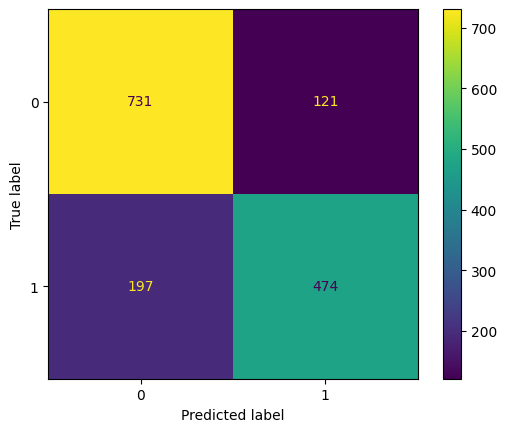

In [12]:
confusion_matrix_model = ConfusionMatrixDisplay(confusion_matrix(y_val, predictions))
confusion_matrix_model.plot()

Let's check which words are most probably associated with actual disasters and which are not.

In [13]:
# list of words (features)
feature_names = np.array(vect.get_feature_names_out())

#list of corresponding coefficients
sorted_coef_index = model.coef_[0].argsort()

print("Words with the smallest Coefficients (i.e. not indicative of a real disaster):\n{}\n".format(feature_names[sorted_coef_index[:20]]))
print("Words with the largest Coefficients (i.e. very indicative of a real disaster): \n{}".format(feature_names[sorted_coef_index[:-21:-1]]))

Words with the smallest Coefficients (i.e. not indicative of a real disaster):
['such' 'bags' 'ebay' 'full' 'new' 'jeb' 'myself' 'nowplaying' 'blew'
 'mayhem' 'art' 'panicking' 'join' 'poll' 'longer' 'long' 'cake' 'blight'
 'jobs' 'put']

Words with the largest Coefficients (i.e. very indicative of a real disaster): 
['hiroshima' 'fires' 'wildfire' 'typhoon' 'earthquake' 'storm' 'massacre'
 'bombing' 'drought' 'mass' 'floods' 'tornado' 'derailment' 'train'
 'flood' 'california' 'damage' 'terrorism' 'terrorist' 'poor']


<a id='improvements'/>

### Improvements
[Back to TOC](#TOC)

Let's try to improve our prediction by considering term frequency using TF-IDF 

In [14]:
#Consider only words that occur in at least 3 tweets.
vect = TfidfVectorizer(min_df=3).fit(X_train)


X_train_vectorized = vect.transform(X_train)

# let's look of some of the words gathered with this method
sorted(vect.vocabulary_.items())[150:160]

[('adult', 150),
 ('advance', 151),
 ('advisory', 152),
 ('af', 153),
 ('affected', 154),
 ('affecting', 155),
 ('affects', 156),
 ('afghan', 157),
 ('afghanistan', 158),
 ('afraid', 159)]

In [15]:
print(
    "The training data now contains {} different words (columns) across {} messages (rows).".format( 
                                                            len(vect.vocabulary_.items()),
                                                            X_train.shape[0]
                                                           )
     )

The training data now contains 3769 different words (columns) across 6090 messages (rows).


In [16]:
# list of words (features)
feature_names = np.array(vect.get_feature_names_out())

#list of corresponding tfidf values
sorted_tfidf_index = X_train_vectorized.toarray().max(0).argsort()

# print words with highest and lowest tfidf values
print("Smallest tfidf:\n{}\n".format(feature_names[sorted_tfidf_index[:20]]))
print("Largest tfidf: \n{}".format(feature_names[sorted_tfidf_index[:-21:-1]]))

Smallest tfidf:
['ksawlyux02' 'trubgme' 'vid' 'sh' 'lgl' 'idis' '8whts' 'colluded'
 '90blks' 'wht' 'hers' 'sm' 'utc2015' 'time2015' 'starring' 'villagers'
 'destiny' 'enemy' 'blessings' 'heavenly']

Largest tfidf: 
['thanks' 'hey' 'screams' 'emergency' 'exploded' 'crushed' 'fatal'
 'fatality' 'thunder' 'girl' 'survive' 'screaming' 'wreck' 'love' 'blight'
 'armageddon' 'what' 'meltdown' 'mudslide' 'murderer']


In [17]:
model = LogisticRegression(max_iter=777)
model.fit(X_train_vectorized, y_train)

# Predict the transformed validation texts
predictions = model.predict(vect.transform(X_val))
predict_probab = model.predict_proba(vect.transform(X_val))[:,1]

print("Accuracy = {:.5f}".format(accuracy_score(y_val, predictions)))
print("AUC = {:.3f}".format(roc_auc_score(y_val, predict_probab)))

Accuracy = 0.80762
AUC = 0.850


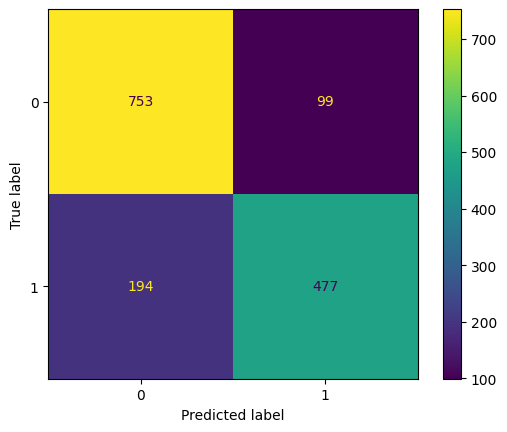

In [18]:
confusion_matrix_model = ConfusionMatrixDisplay(confusion_matrix(y_val, predictions))
confusion_matrix_model.plot()

In [19]:
# list of words (features)
feature_names = np.array(vect.get_feature_names_out())

#list of corresponding coefficients
sorted_coef_index = model.coef_[0].argsort()

print("Words with the smallest Coefficients (i.e. not indicative of a real disaster):\n{}\n".format(feature_names[sorted_coef_index[:20]]))
print("Words with the largest Coefficients (i.e. very indicative of a real disaster): \n{}".format(feature_names[sorted_coef_index[:-21:-1]]))

Words with the smallest Coefficients (i.e. not indicative of a real disaster):
['you' 'my' 'new' 'full' 'body' 'bags' 'love' 'panic' 'your' 'he' 'ebay'
 'https' 'flattened' 'crush' 'blew' 'me' 'lol' 'screams' 'blight' 'such']

Words with the largest Coefficients (i.e. very indicative of a real disaster): 
['hiroshima' 'fires' 'in' 'california' 'storm' 'mass' 'train' 'wildfire'
 'fire' 'bombing' 'typhoon' 'killed' 'massacre' 'disaster' 'earthquake'
 'drought' 'japan' 'near' 'suicide' 'derailment']


Using TF-IDF, we have increased our accuracy score slightly.

Let's make the texts more comparable by using stemming.

In [20]:
stemmer = nltk.PorterStemmer()
cv_analyzer = TfidfVectorizer(min_df=2).build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in cv_analyzer(doc))

stem_vectorizer = TfidfVectorizer(min_df=2, analyzer = stemmed_words)
X_train_stem_vectorized = stem_vectorizer.fit_transform(X_train)

In [21]:
model = LogisticRegression(max_iter=777)
model.fit(X_train_stem_vectorized, y_train)

# Predict the transformed validation texts
predictions = model.predict(stem_vectorizer.transform(X_val))
predict_probab = model.predict_proba(stem_vectorizer.transform(X_val))[:,1]

print("Accuracy = {:.5f}".format(accuracy_score(y_val, predictions)))
print("AUC = {:.3f}".format(roc_auc_score(y_val, predict_probab)))

Accuracy = 0.79908
AUC = 0.851


Stemming reduces the accuracy again. What about Lemmatization?

In [22]:
WNlemma = nltk.WordNetLemmatizer()
cv_analyzer = TfidfVectorizer(min_df=4).build_analyzer()


def lemmatize_word(doc):
    return (WNlemma.lemmatize(t) for t in cv_analyzer(doc))

lemm_vectorizer = TfidfVectorizer(min_df=4, analyzer = lemmatize_word)


X_train_lemm_vectorized = lemm_vectorizer.fit_transform(X_train)

In [23]:
model = LogisticRegression(max_iter=777)
model.fit(X_train_lemm_vectorized, y_train)

# Predict the transformed validation texts
predictions = model.predict(lemm_vectorizer.transform(X_val))
predict_probab = model.predict_proba(lemm_vectorizer.transform(X_val))[:,1]

print("Accuracy = {:.5f}".format(accuracy_score(y_val, predictions)))
print("AUC = {:.3f}".format(roc_auc_score(y_val, predict_probab)))

Accuracy = 0.80499
AUC = 0.851


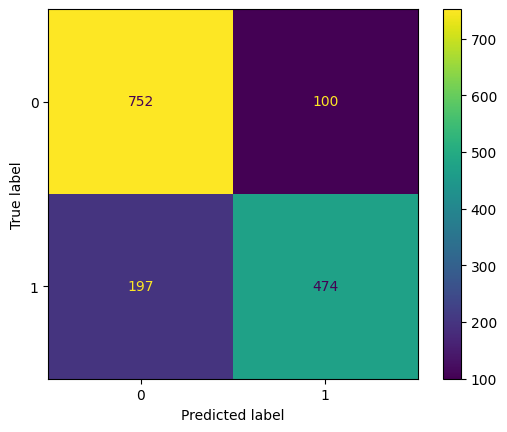

In [24]:
confusion_matrix_model = ConfusionMatrixDisplay(confusion_matrix(y_val, predictions))
confusion_matrix_model.plot()

Nope. Lemmatization slightly reduces the accuracy score compared to the unchanged TF-IDF vectorized data.